In [1]:
import PIL
import tensorflow as tf

# Defining datasets

We will use a custom preprocessed version of IAM dataset, where each image has been converted to a vectorized list of paths using the Potrace algorithm.

## Input structure

In [2]:
from os import path

minibez_path = "/kaggle/input/minibez"
iam_words_path = "/kaggle/input/iamdatasets/IAM_Words/iam_words"

In [3]:
def read_words():    
    def get_id_and_word(line_data:list):           
        return (line_data[0], "".join(line_data[8:]), line_data[1]=="ok")
    
    with open(path.join(iam_words_path, "..","words_new.txt")) as f:
        return [get_id_and_word(line.split()) for line in f.readlines() if not line.startswith("#")]        

read_words()[:5]

[('a01-000u-00-00', 'A', True),
 ('a01-000u-00-01', 'MOVE', True),
 ('a01-000u-00-02', 'to', True),
 ('a01-000u-00-03', 'stop', True),
 ('a01-000u-00-04', 'Mr.', True)]

[[199.0, 0.8, 189.0, 0.3, 186.0, 3.8, 1.0], [186.0, 3.8, 183.0, 7.3, 183.5, 8.3, 0.263], [183.5, 8.3, 184.0, 9.3, 189.0, 7.8, 0.478], [189.0, 7.8, 194.0, 6.3, 202.0, 5.8, 0.211], [202.0, 5.8, 210.0, 5.3, 211.5, 3.8, 0.489]]


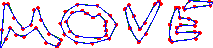

In [4]:
def get_paths_file(word_id:str):    
    split_id = word_id.split("-")    
    return path.join(minibez_path, split_id[0], "-".join(split_id[:-2]), word_id+".txt")

def paths_file_exists(word_id:str): 
    return path.exists(get_paths_file(word_id))    

def read_paths(word_id:str):
    split_id = word_id.split("-")    
    
    with open(get_paths_file(word_id), "r") as f:
        return [list(map(float,line.strip().split(","))) for line in f.readlines()]        

print(read_paths("a01-000u-00-01")[:5])
PIL.Image.open("/kaggle/input/minibez/a01/a01-000u/a01-000u-00-01.png")

## Reading input

In [5]:
detected_chars = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

def text_to_labels(text):
    return [detected_chars.index(c) for c in text]    

In [6]:
import numpy as np
from random import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_test_split_factor = 0.8

def read_dataset():
    train_input = []
    train_output = []
    test_input = []
    test_output = []
    
    max_label_len = 30
    
    for (word_id, word_text, word_ok) in read_words()[:11]:        
        if not word_ok: continue                       
        if not paths_file_exists(word_id): continue
        
        word_paths = read_paths(word_id)        
        for path in word_paths:
            for i in range(0,3):
                path[2*i]/=128
                path[2*i+1]/=32
        
        (i, o) = (train_input, train_output) if random() < train_test_split_factor else (test_input, test_output)
        i.append(np.array(word_paths))
        o.append(text_to_labels(word_text))        
        max_label_len = max(max_label_len, len(word_text))
        
    train_output = pad_sequences(train_output, maxlen=max_label_len, padding='post',
                             value=len(detected_chars)) #.reshape(-1,1,max_label_len)    
    test_output = pad_sequences(test_output, maxlen=max_label_len, padding='post',
                             value=len(detected_chars)) #.reshape(-1,1,max_label_len)
        
    #train_input = np.array(train_input, dtype=np.ndarray)
    #test_input = np.array(test_input, dtype=np.ndarray)
        
    return (train_input, train_output, test_input, test_output, max_label_len)

(train_input, train_output, test_input, test_output, max_label_len) = read_dataset()


In [7]:
np.set_printoptions(threshold=10)
print("Input")
print(train_input[1])
print("Output")
print(train_output[1])

Input
[[0.071875   1.265625   0.103125   ... 0.11484375 1.171875   0.541     ]
 [0.11484375 1.171875   0.1265625  ... 0.15       1.0625     0.333     ]
 [0.15       1.0625     0.1734375  ... 0.18125    0.984375   0.071     ]
 ...
 [0.41640625 1.30625    0.4671875  ... 0.47109375 1.134375   1.        ]
 [0.47109375 1.134375   0.475      ... 0.46328125 0.9        0.452     ]
 [0.46328125 0.9        0.4515625  ... 0.3890625  0.775      1.        ]]
Output
[71 66 78 ... 78 78 78]


In [8]:
print(train_input[0].shape)
print(train_input[1].shape)

print(train_output[1].shape)

print(f"max_label_len = {max_label_len}")

(77, 7)
(31, 7)
(30,)
max_label_len = 30


# Model

In [9]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(None, 7,))            
    
    lstm0 = tf.keras.layers.LSTM(512, activation='tanh')(inputs),    
    #reshape = tf.keras.layers.Reshape((512, 1))(lstm0[0])            
    flatten = tf.keras.layers.Flatten()(lstm0[0])
    lstm1 = tf.keras.layers.Dense(128, activation='relu')(flatten),    
    lstm1 = tf.keras.layers.Dense(64, activation='tanh')(flatten),    
    reshape1 = tf.keras.layers.Reshape((64, 1))(lstm1[0])           
    
    
    blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout = 0.1))(reshape1)
    blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout = 0.1))(blstm_1)
            
    
    outputs = tf.keras.layers.Dense(len(detected_chars)+1, activation = 'softmax')(blstm_2)
    
    model = tf.keras.Model(inputs, outputs)
    return model, inputs, outputs

act_model, inputs, outputs = create_model()
act_model.summary(90)

_="""
def create_model():
    inputs = tf.keras.layers.Input(shape=(None, 7,))            
    
    lstm0 = tf.keras.layers.LSTM(64, activation='tanh')(inputs),    
    reshape = tf.keras.layers.Reshape((64,1))(lstm0[0])        
    
    blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout = 0.2))(reshape)
    blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
        
    #flatten = tf.keras.layers.Flatten()(blstm_2)    
    outputs = tf.keras.layers.Dense(len(detected_chars)+1, activation = 'softmax')(blstm_2)
    
    model = tf.keras.Model(inputs, outputs)
    return model, inputs, outputs

act_model, inputs, outputs = create_model()
act_model.summary(90)
"""


Model: "model"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 input_1 (InputLayer)                   [(None, None, 7)]                   0             
                                                                                          
 lstm (LSTM)                            (None, 512)                         1064960       
                                                                                          
 flatten (Flatten)                      (None, 512)                         0             
                                                                                          
 dense_1 (Dense)                        (None, 64)                          32832         
                                                                                          
 reshape (Reshape)                      (None, 64, 1)                      

In [10]:
def training_model():
    the_labels = tf.keras.layers.Input(name='the_labels', shape=[max_label_len], dtype='float32')
    input_length = tf.keras.layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = tf.keras.layers.Input(name='label_length', shape=[1], dtype='int64')    
    
    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args        
        y_pred = y_pred[:, 2:, :]       
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length, )                            
    
    
    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, name='ctc')([outputs, the_labels, input_length, label_length])    
    
    #model to be used at training time
    model = tf.keras.models.Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)
    return model
model = training_model()

In [11]:
train_input_len = np.array([[max_label_len] for i in range(len(train_input))])
train_output_len = np.array([[len(train_output[i])] for i in range(len(train_output))])

dataset_in = tf.data.Dataset.from_generator(
    lambda: zip([[train_input[i]] for i in range(len(train_input))], [[x] for x in train_output], train_input_len, train_output_len),     
    output_signature=(
        tf.TensorSpec((1, None, 7), dtype=tf.as_dtype(train_input[0].dtype)),
        tf.TensorSpec([1, len(train_output[0])], dtype=tf.as_dtype(train_output[0].dtype)),
        tf.TensorSpec([1], dtype=tf.as_dtype(train_input_len[0].dtype)),
        tf.TensorSpec([1], dtype=tf.as_dtype(train_output_len[0].dtype)),
    )
)

dataset_out = tf.data.Dataset.from_generator(
    lambda: tf.constant(np.array([[0]]*len(train_input))),
    output_signature = tf.TensorSpec([1], dtype=tf.int32)
)

dataset = tf.data.Dataset.zip((dataset_in, dataset_out))

k=0
for x in dataset:
    print(f"({x[0][0].shape},{x[0][1].shape},{x[0][2].shape},{x[0][3].shape})->{x[1].shape}")            
    print(x[0])
    break    

print()

print(len(train_input))

((1, 77, 7),(1, 30),(1,),(1,))->(1,)
(<tf.Tensor: shape=(1, 77, 7), dtype=float64, numpy=
array([[[1.5546875 , 0.025     , 1.4765625 , ..., 1.453125  ,
         0.11875   , 1.        ],
        [1.453125  , 0.11875   , 1.4296875 , ..., 1.43359375,
         0.259375  , 0.263     ],
        [1.43359375, 0.259375  , 1.4375    , ..., 1.4765625 ,
         0.24375   , 0.478     ],
        ...,
        [0.5359375 , 0.51875   , 0.5125    , ..., 0.528125  ,
         0.815625  , 1.        ],
        [0.528125  , 0.815625  , 0.54375   , ..., 0.57109375,
         1.05      , 0.48      ],
        [0.57109375, 1.05      , 0.5984375 , ..., 0.684375  ,
         1.159375  , 0.625     ]]])>, <tf.Tensor: shape=(1, 30), dtype=int32, numpy=array([[38, 40, 47, ..., 78, 78, 78]], dtype=int32)>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([30])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([30])>)

10


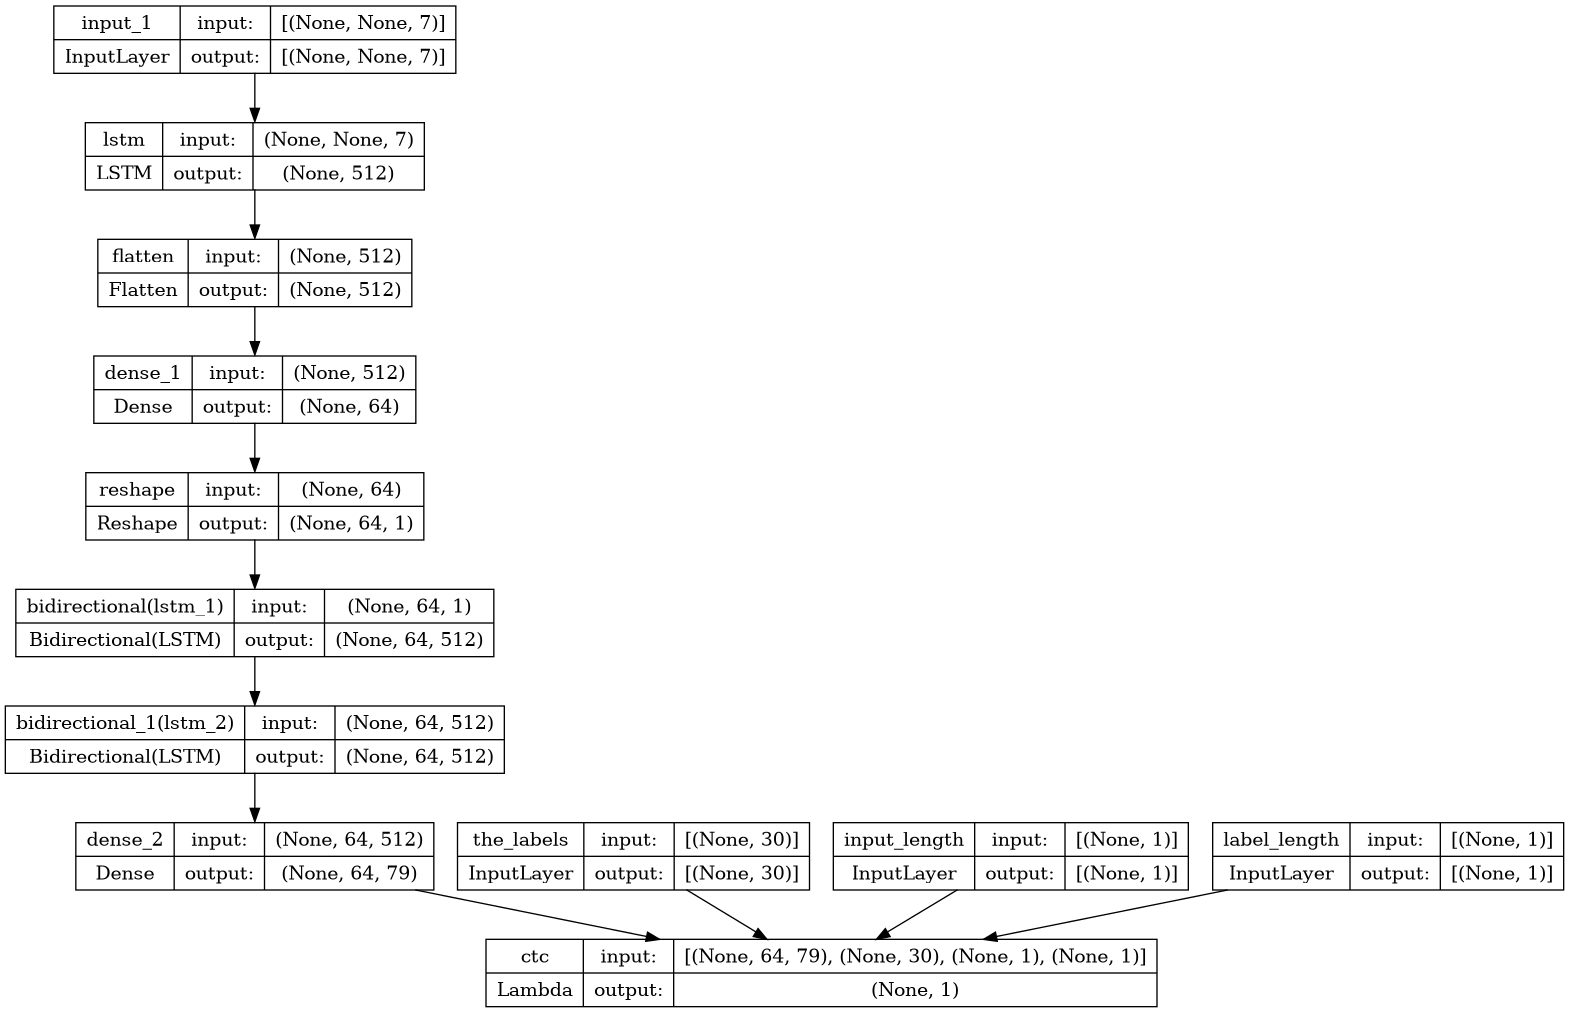

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'sgd', metrics=["accuracy"])

history = model.fit(dataset,    
                    batch_size=5,
                    epochs=600,                     
                    verbose=2,                       
                    #callbacks=callbacks_list
                   )


Epoch 1/600
10/10 - 14s - loss: 54.9385 - accuracy: 0.0000e+00 - 14s/epoch - 1s/step
Epoch 2/600
10/10 - 4s - loss: 24.1944 - accuracy: 0.0000e+00 - 4s/epoch - 415ms/step
Epoch 3/600
10/10 - 4s - loss: 22.7811 - accuracy: 0.0000e+00 - 4s/epoch - 417ms/step
Epoch 4/600
10/10 - 4s - loss: 21.9421 - accuracy: 0.0000e+00 - 4s/epoch - 398ms/step
Epoch 5/600
10/10 - 4s - loss: 21.3396 - accuracy: 0.0000e+00 - 4s/epoch - 405ms/step
Epoch 6/600
10/10 - 4s - loss: 20.8931 - accuracy: 0.0000e+00 - 4s/epoch - 411ms/step
Epoch 7/600
10/10 - 4s - loss: 20.5247 - accuracy: 0.0000e+00 - 4s/epoch - 399ms/step
Epoch 8/600
10/10 - 4s - loss: 20.2561 - accuracy: 0.0000e+00 - 4s/epoch - 413ms/step
Epoch 9/600
10/10 - 4s - loss: 20.0299 - accuracy: 0.0000e+00 - 4s/epoch - 397ms/step
Epoch 10/600
10/10 - 4s - loss: 19.8036 - accuracy: 0.0000e+00 - 4s/epoch - 430ms/step
Epoch 11/600
10/10 - 4s - loss: 19.6429 - accuracy: 0.0000e+00 - 4s/epoch - 389ms/step
Epoch 12/600
10/10 - 4s - loss: 19.5020 - accuracy: 0

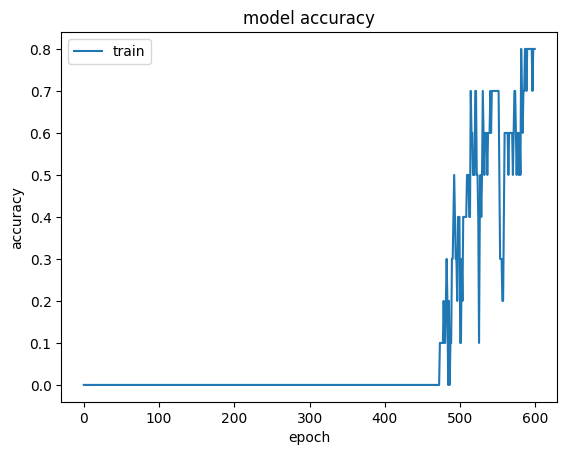

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()